<a href="https://colab.research.google.com/github/andrewcleung/aps360-currency-detector/blob/alex-model/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group 30 Currency detector
## Members
Emily Hu, Lawrence Fan, Kenro Oyama, Andrew Leung
## Introduction
This notebook contains the codebase for the curreny detector model. It utilize alex net's pretrained data, and applied a simple CNN and FCC layer afterwards for the classification problem

# Installing Dependencies


In [1]:
#@title
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
#Paths
root = "drive/MyDrive/Xiang Jia Wei Xin Ma/APS360"
photo = '/dataset'
alexnet_features = '/alex_features'
weights = '/model_weights'
dataset_path = root + photo
features_path = root + alexnet_features
weights_path = root + weights

In [6]:
print(dataset_path)

drive/MyDrive/Xiang Jia Wei Xin Ma/APS360/dataset


# Load the data

Following code is copied from a updated version of pytorch to use percentage in ramdon split

In [7]:
import math
from torch import default_generator, randperm
from torch._utils import _accumulate
from torch.utils.data.dataset import Subset

def random_split(dataset, lengths,
                 generator=default_generator):
    r"""
    Randomly split a dataset into non-overlapping new datasets of given lengths.

    If a list of fractions that sum up to 1 is given,
    the lengths will be computed automatically as
    floor(frac * len(dataset)) for each fraction provided.

    After computing the lengths, if there are any remainders, 1 count will be
    distributed in round-robin fashion to the lengths
    until there are no remainders left.

    Optionally fix the generator for reproducible results, e.g.:

    >>> random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))
    >>> random_split(range(30), [0.3, 0.3, 0.4], generator=torch.Generator(
    ...   ).manual_seed(42))

    Args:
        dataset (Dataset): Dataset to be split
        lengths (sequence): lengths or fractions of splits to be produced
        generator (Generator): Generator used for the random permutation.
    """
    if math.isclose(sum(lengths), 1) and sum(lengths) <= 1:
        subset_lengths: List[int] = []
        for i, frac in enumerate(lengths):
            if frac < 0 or frac > 1:
                raise ValueError(f"Fraction at index {i} is not between 0 and 1")
            n_items_in_split = int(
                math.floor(len(dataset) * frac)  # type: ignore[arg-type]
            )
            subset_lengths.append(n_items_in_split)
        remainder = len(dataset) - sum(subset_lengths)  # type: ignore[arg-type]
        # add 1 to all the lengths in round-robin fashion until the remainder is 0
        for i in range(remainder):
            idx_to_add_at = i % len(subset_lengths)
            subset_lengths[idx_to_add_at] += 1
        lengths = subset_lengths
        for i, length in enumerate(lengths):
            if length == 0:
                warnings.warn(f"Length of split at index {i} is 0. "
                              f"This might result in an empty dataset.")

    # Cannot verify that dataset is Sized
    if sum(lengths) != len(dataset):    # type: ignore[arg-type]
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = randperm(sum(lengths), generator=generator).tolist()  # type: ignore[call-overload]
    return [Subset(dataset, indices[offset - length : offset]) for offset, length in zip(_accumulate(lengths), lengths)]

In [9]:
def get_data_loader(batch_size = 64, num_workers = 0):
  classes = ['cad_1_coin', 'usd_1_bill', 'cad_2_coin', 'cad_5_bill', 'usd_5_bill', 'cad_10_bill', 'usd_10_bill', 'cad_20_bill', 'usd_20_bill',
             'cad_50_bill', 'usd_50_bill', 'cad_100_bill', 'usd_100_bill', 'usd_1_cent_coin', 'cad_5_cent_coin', 'usd_5_cent_coin', 'cad_10_cent_coin', 'usd_10_cent_coin',
             'cad_25_cent_coin', 'usd_25_cent_coin']
  transform = transforms.Compose(
        [transforms.Resize((224,224)),
         transforms. transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)
  train_set, valid_set, test_set = random_split(dataset, [0.6, 0.2, 0.2])

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers = num_workers,shuffle=True)
  valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, num_workers = num_workers,shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers = num_workers,shuffle=True)
  return train_loader, valid_loader, test_loader, classes
  

In [10]:
test_train_loader, test_valid_loader, test_test_loader, _ = get_data_loader(1)
#Validation
print(len(test_train_loader))
print(len(test_valid_loader))
print(len(test_test_loader))

# the output is equal to the number of pictures

2510
837
836


# The model

## helper functions

In [19]:
from math import floor
def get_conv_width(width, kernel_size = 3,  stride = 1 , padding = 0):
  return floor(((width - kernel_size + 2*padding)/stride) + 1)


In [20]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

In [61]:
def get_folder_name(name, batch_size, learning_rate):
  path = "model_{0}_bs{1}_lr{2}".format(name, batch_size, learning_rate)
  return path

In [21]:
def get_accuracy(model, data_loader):
  correct = 0
  total = 0
  for imgs, labels in iter(data_loader):
      
      if torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()

      output = model(imgs)
      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]
  return correct / total


In [63]:
def train_model(model, train_loader, val_loader, batch_size = 32, num_epochs = 20, learning_rate = 1e-4):
  torch.manual_seed(10)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  train_acc = np.zeros(num_epochs)
  val_acc = np.zeros(num_epochs)
  epochs = []

  # Training
  print("Training start")
  
  for epoch in range(num_epochs):
    for imgs, labels in iter(train_loader):
      if torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      
      pred = model(imgs)
      loss = criterion(pred, labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    train_acc[epoch] = get_accuracy(model, train_loader)
    val_acc[epoch] = get_accuracy(model, val_loader)

    print(("Epoch {}: Train accuracy: {}, Validation accuracy: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   val_acc[epoch]))
    model_path = get_model_name(model.name, batch_size ,learning_rate, epoch)
    folder_path = weights_path + '/' + get_folder_name(model.name, batch_size, learning_rate)
    if not os.path.isdir(folder_path):
      os.mkdir(folder_path)
    torch.save(model.state_dict(), folder_path + '/' + model_path)
    epochs.append(epoch + 1)

  return train_acc, val_acc, epochs



## Legacy CNN implementation

To speed up the training, our team have decided not to train the CNN network, but instead use the pretrained data from AlexNet

In [11]:
class ConvNet(nn.Module):
  def __init__(self, batch_size = 32, num_classes = 20):
    super(ConvNet, self).__init__()
    self.name = "initNet"
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4)
    self.bn1 = nn.BatchNorm2d(num_features=96)

    self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)

    self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)

    self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)

    self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(num_features=256)  

    # pool
    self.pool = nn.MaxPool2d(3,2)

    # fully connected network
    self.fc1 = nn.Linear(5*5*256, 100)
    self.fc2 = nn.Linear(100, num_classes)

    # dropout
    self.dropout = nn.Dropout()

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.pool(F.relu(x))

    x = self.pool(F.relu(self.conv2(x)))
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.pool(F.relu(self.conv5(x)))

    x = x.view(-1, 5*5*256)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))

    return x



## Alex net implementation


### Converting the data into alex net features

In [12]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [71]:
# Prepare dataloader
batch_size = 1
num_workers = 1

train_data_loader, val_data_loader, test_data_loader, classes = get_data_loader(batch_size = batch_size, num_workers=num_workers)

print(len(train_data_loader))
print(len(val_data_loader))
print(test_data_loader.dataset)
# it seems like the dataset is pointing at the same object regardless of the object

2510
837


In [ ]:
# save features to folder as tensors
n = 0
for img, label in train_data_loader.dataset:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = features_path + '/train/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1

n = 0
for img, label in val_data_loader.dataset:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = features_path + '/val/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1

n = 0
for img, label in test_data_loader.dataset:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = features_path + '/test/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1


### loading the tensor files from folder


In [44]:
dir_path = '/content/drive/MyDrive/Xiang Jia Wei Xin Ma/APS360/alex_features/train'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
  print(path)
  for file in os.listdir(os.path.join(dir_path,path)):
    if os.path.isfile(os.path.join(dir_path, path, file)):
        count += 1
  break
print('File count:', count)

cad_20_bill
File count: 210


In [46]:
print("Loading data from", features_path)
def get_feature_data_loader(batch_size = 32, num_workers = 1):
  features_dataset = torchvision.datasets.DatasetFolder(features_path + '/train', loader=torch.load, extensions=('.tensor'))
  train_features, val_features, test_features = random_split(features_dataset, [0.6,0.2,0.2])
  # Prepare the dataloader for alex net
  train_feature_loader = torch.utils.data.DataLoader(train_features, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
  val_feature_loader = torch.utils.data.DataLoader(val_features, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
  test_feature_loader = torch.utils.data.DataLoader(test_features, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
  return train_feature_loader, val_feature_loader, test_feature_loader


Loading data from drive/MyDrive/Xiang Jia Wei Xin Ma/APS360/alex_features


In [47]:
train_feature_loader, val_feature_loader, test_feature_loader = get_feature_data_loader()
# Verification Step - obtain one batch of features
dataiter = iter(train_feature_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)

torch.Size([32, 256, 6, 6])
torch.Size([32])


### The Alex model

In [24]:
torch.manual_seed(10) # set random seed
from math import floor

class AlexNet(nn.Module):
  def __init__(self, name="Alex Net", num_classes = 20):
    super(AlexNet, self).__init__()
    self.name = name
    self.conv1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
    self.pool = nn.MaxPool2d(2 ,2)

    self.fc1 = nn.Linear(2 * 2 * 512, 64)
    self.fc2 = nn.Linear(64, num_classes)

  def forward(self, features):
    x = self.pool(F.relu(self.conv1(features)))
    x  = x.view(-1, 2*2*512)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.softmax(x, dim=1)


In [66]:
net = AlexNet()
if torch.cuda.is_available():
  net.cuda()


train_acc, val_acc, epochs = train_model(net, train_feature_loader, val_feature_loader, batch_size=128, num_epochs=20, learning_rate=1e-4)

Training start
Epoch 1: Train accuracy: 0.5713147410358566, Validation accuracy: 0.5615292712066906
Epoch 2: Train accuracy: 0.7243027888446215, Validation accuracy: 0.7120669056152927
Epoch 3: Train accuracy: 0.8135458167330677, Validation accuracy: 0.8183990442054958
Epoch 4: Train accuracy: 0.8310756972111554, Validation accuracy: 0.8183990442054958
Epoch 5: Train accuracy: 0.8386454183266933, Validation accuracy: 0.8375149342891278
Epoch 6: Train accuracy: 0.8426294820717132, Validation accuracy: 0.8387096774193549
Epoch 7: Train accuracy: 0.8446215139442231, Validation accuracy: 0.8422939068100358
Epoch 8: Train accuracy: 0.8450199203187251, Validation accuracy: 0.8399044205495818
Epoch 9: Train accuracy: 0.8450199203187251, Validation accuracy: 0.8339307048984468
Epoch 10: Train accuracy: 0.8458167330677291, Validation accuracy: 0.8410991636798089
Epoch 11: Train accuracy: 0.8474103585657371, Validation accuracy: 0.8470728793309439
Epoch 12: Train accuracy: 0.849800796812749, Val

#### plotting the result

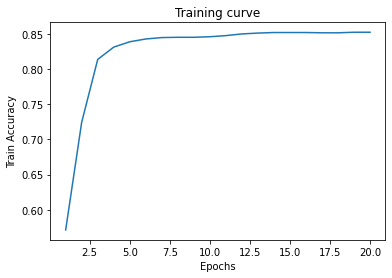

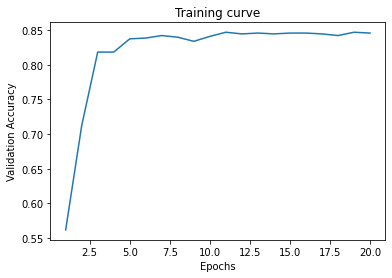

In [67]:
plt.plot(epochs, train_acc)
plt.title("Training curve")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.show()

plt.plot(epochs, val_acc)
plt.title("Training curve")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

# Testing our models accuracy

In [60]:
print(get_accuracy(net, test_feature_loader))

0.8301435406698564
